In [1]:
from astropy.io import fits 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
params = [
    [{'sigma':0.02, 'h':25,'rho':1.0},
    {'sigma':0.02, 'h':50,'rho':1.0},
    {'sigma':0.02, 'h':75,'rho':1.0}],
    
    [{'sigma':0.02, 'h':50,'rho':1.0},
    {'sigma':0.01, 'h':50,'rho':1.0},
    {'sigma':0.005, 'h':50,'rho':1.0}],
    
    [{'sigma':0.02, 'h':5,'rho':1.0},
    {'sigma':0.01, 'h':5,'rho':1.0},
    {'sigma':0.005, 'h':5,'rho':1.0}]
    ]

N_mis = 10000
TEST_NUMBER = 1

In [3]:
def Covariance(matrix,average = False):
    AVE = matrix.mean(axis = 0)
    dim_matrix = len(matrix[0,:])
    D = []
    
    for i in range(dim_matrix):
        D.append(matrix[:,i]-AVE[i])
    D = np.array(D)
    
    cov = np.matmul(D,D.T)
    
    if average:
        return AVE, cov
    else:
        return np.array(cov)/(len(matrix[:,0])-1)
    
def Read(N_mis,test,keyword):
    
    measures = []
    for i in tqdm(np.arange(N_mis)+1,dynamic_ncols=True,desc='Reading: '):
        fname = f'dati/data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits'
        
        file = fits.open(fname)
        table = file[1].data.copy()
        measures.append(table[keyword])
        if (i==1):
            scale = table['SCALE']
        del table
        file.close()
    return np.array(measures), np.array(scale)

def Correlation(matrix):
    dim_matrix = matrix.shape
    diag = np.diag(matrix)
    COV = np.zeros(dim_matrix)
    for i in range(dim_matrix[0]):
        for j in range(dim_matrix[1]):
            COV[i,j]=matrix[i,j]/np.sqrt(diag[i]*diag[j])
    return COV


def Th_Covariance(distance,multipoli, params):
    l_1 = multipoli[0]
    l_2 = multipoli[1]
    somma_h = params[l_1]['h']**2+params[l_2]['h']**2
    dim = len(distance)
    COV = np.zeros((dim,dim))
    if (multipoli[0]==multipoli[1]):
        for i in range(dim):
            for j in range(dim):
                COV[i,j] = (params[l_1]['sigma']**2)*np.exp(-((distance[i]-distance[j])**2)/(2*params[l_1]['h']**2))
        return COV
    elif (multipoli[0] != multipoli[1]):
        for i in range(dim):
            for j in range(dim):
                COV[i,j] = (params[l_1]['sigma']*params[l_2]['sigma'])*np.sqrt((2*params[l_1]['h']*params[l_2]['h'])/(somma_h))*np.exp(-((distance[i]-distance[j])**2)/somma_h)
        return COV

def Res(th_covariance,covariance,N_mis,N_bins = 200):
    TH_CORR = Correlation(th_covariance)
    RES = np.zeros((N_bins,N_bins))
    diag = np.diag(th_covariance)
    for i in range(N_bins):
        for j in range(N_bins):
            RES[i,j] = (th_covariance[i,j] - covariance[i,j])*np.sqrt((N_mis-1)/((1+TH_CORR[i,j])*diag[i]*diag[j]))
    return RES


def plot_figure(array_matrix, cmap = 'viridis',size = (7,5),title = ''):
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111)
    ax.set_title(title)
    plt.imshow(array_matrix,cmap=cmap)
    ax.set_aspect('equal')

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical',ax = ax)
    plt.show()
        
    return

def plot_figures(array_matrix1,array_matrix2, cmap = 'viridis',size = (7,5),title_1 = '',title_2 = ''):
    fig = plt.figure(figsize=size)
    gs = fig.add_gridspec(1,2, wspace = 0.1)
    axs = gs.subplots(sharey=True)
    map1 = axs[0].imshow(array_matrix1,cmap = cmap)
    map2 = axs[1].imshow(array_matrix2,cmap = cmap)

    axs[0].set_title(title_1, fontsize = 20)
    axs[1].set_title(title_2, fontsize = 20)
    axs[0].set_xlabel('N Bins',fontsize = 16)
    axs[1].set_xlabel('N Bins',fontsize = 16)
    axs[0].set_ylabel('N Bins',fontsize = 16)
    cbar1 = plt.colorbar(map1,orientation = 'horizontal',ax=axs[1])
    cbar2 = plt.colorbar(map2,orientation = 'horizontal',ax=axs[0])
    
    cbar1.ax.tick_params(labelsize = 12)
    cbar2.ax.tick_params(labelsize = 12)
    return


def Cross_covariance(matrix):
    D = [[],[],[]]
    cov = []
    for j in range(len(matrix)):
        AVE = matrix[j].mean(axis = 0)
        dim_matrix = len(matrix[j][0,:])
        
        for i in range(dim_matrix):
            D[j].append(matrix[j][:,i]-AVE[i])
        D[j] = np.array(D[j])
        del AVE
    for k in range(3):
        for l in range(3):
            cov.append(np.matmul(D[k],D[l].T)/(len(matrix[0][:,0])-1))
    
    return np.array(cov)

def block_matrix(matrix):
    COVV2 = np.concatenate(matrix[0:3])
    COVV3 = np.concatenate(matrix[3:6])
    COVV4 = np.concatenate(matrix[6:9])
    
    return np.concatenate((COVV2,COVV3,COVV4),axis=1)

def Res_cross(th_matrix,matrix,N_mis,N_bins = 200):
    RES = []
    for k in range(9):
        RES.append(Res(th_matrix[k],matrix[k],N_mis))
        
    return np.array(RES)

def Th_Cross_Covariance(matrix,params):
    theoretical_cross_correlation = []
    for i in range(3):
        for j in range(3):
            theoretical_cross_correlation.append(Th_Covariance(matrix[i],[i,j],params))
        
    return np.array(theoretical_cross_correlation)

In [41]:
measures,distance = Read(N_mis = N_mis,test = TEST_NUMBER,keyword = 'XI0')

Reading: 100%|██████████| 10000/10000 [02:57<00:00, 56.43it/s]


Check passed. Max difference: 5.421010862427522e-20


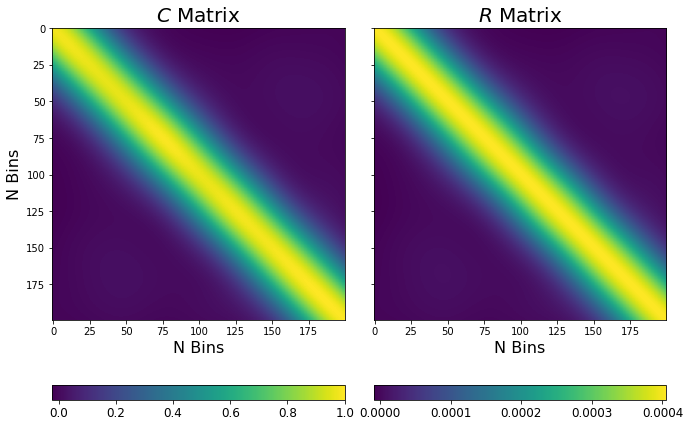

In [42]:
COV = np.cov(measures.T)
MYCOV = Covariance(measures)
CORR = Correlation(COV)

epsilon = 1e-15
MAX_DIFF = np.max(np.abs(COV-MYCOV))
if MAX_DIFF < epsilon:
    print(f'Check passed. Max difference: {MAX_DIFF}')
else:
    print(f'WARNING! Max difference: {MAX_DIFF} > {epsilon}')

plot_figures(COV,CORR,title_1 = '$C$ Matrix',title_2='$R$ Matrix',size = (11,8))

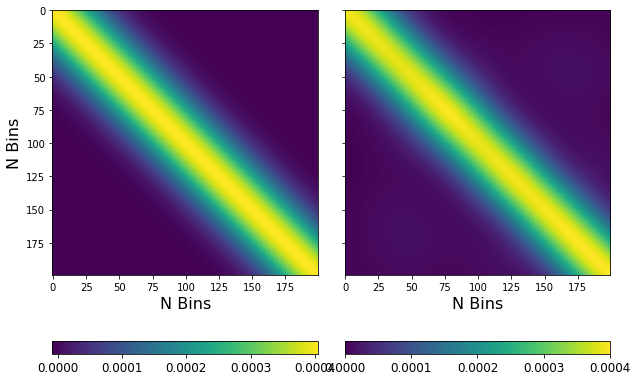

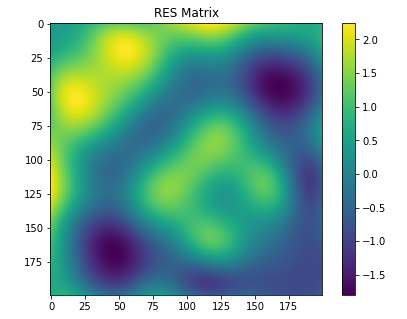

Standard deviation: 0.9471380341783252


In [43]:
TH_COV = Th_Covariance(distance,[0,0],params[0])
RES = Res(TH_COV,COV,N_mis)
plot_figures(TH_COV,COV,size = (10,8))

plot_figure(RES,title = 'RES Matrix')
print(f'Standard deviation: {np.std(RES.reshape(200*200))}')

In [4]:
keyword_list = ['XI0','XI2','XI4']
data_distance = []
data_measures = []
for dipoles in keyword_list:
    print(f'Reading dipole {dipoles}...')
    temp0,temp1 = Read(N_mis = N_mis,test = TEST_NUMBER,keyword = dipoles)
    data_distance.append(temp1)
    data_measures.append(temp0)
    del temp0
    del temp1

Reading dipole XI0...


Reading: 100%|██████████| 10000/10000 [02:13<00:00, 74.78it/s]


Reading dipole XI2...


Reading: 100%|██████████| 10000/10000 [02:09<00:00, 77.10it/s]


Reading dipole XI4...


Reading: 100%|██████████| 10000/10000 [02:30<00:00, 66.59it/s]


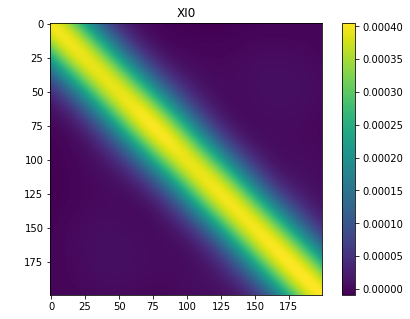

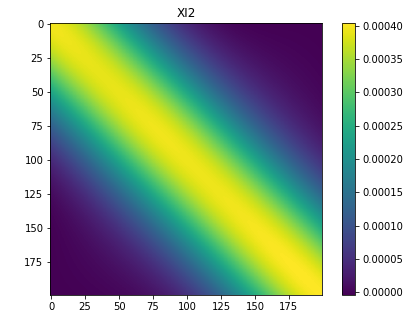

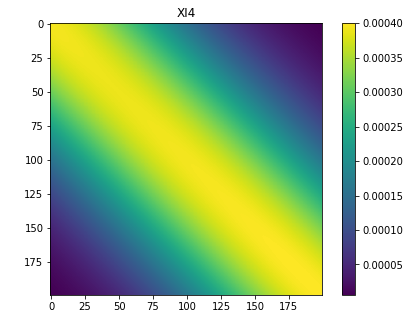

In [5]:
COVARIANCE = []
CORRELATION = []
for i in range(len(data_measures)):
    COVARIANCE.append(Covariance(data_measures[i]))
    CORRELATION.append(Correlation(COVARIANCE[i]))

for i in range(len(data_measures)):
    plot_figure(COVARIANCE[i],title=keyword_list[i])  

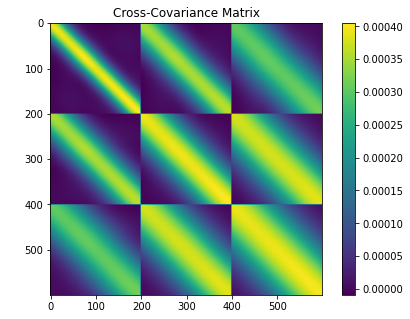

In [6]:
TOT_COVARIANCE = Cross_covariance(data_measures)
BLOCK_COVARIANCE = block_matrix(TOT_COVARIANCE)
plot_figure(BLOCK_COVARIANCE,title='Cross-Covariance Matrix')

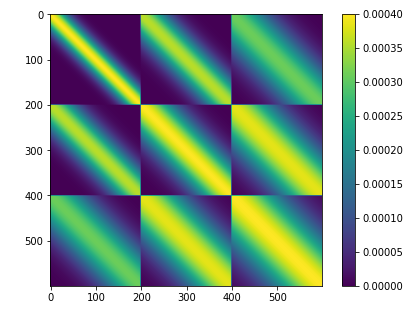

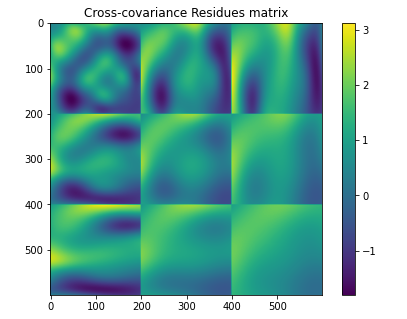

Standard deviation: 0.9114166373941788


In [7]:
test = TEST_NUMBER-1
TH_CROSS_COV = Th_Cross_Covariance(data_distance,params[test])
BLOCK_CROSS_COVARIANCE = block_matrix(TH_CROSS_COV)
plot_figure(BLOCK_CROSS_COVARIANCE)
CROSS_RES = Res_cross(TH_CROSS_COV,TOT_COVARIANCE,N_mis)
plot_figure(block_matrix(CROSS_RES),title='Cross-covariance Residues matrix')
print(f'Standard deviation: {np.std(CROSS_RES.reshape(600*600))}')